# Machine learning at CoDaS-HEP 2024, lesson 1 part 2

<br><br><br><br><br>

## Reminders

As a reminder, a (simple, feed-forward, 4-layer) neural network looks like this:

<img src="../img/artificial-neural-network-layers-2.svg" width="700">

<br><br><br><br><br>

Which is to say, like this:

$$
y_i =
f\left(a_{i,j}^{\mbox{\scriptsize L3-L4}} \cdot
f\left(a_{i,j}^{\mbox{\scriptsize L2-L3}} \cdot
f\left(a_{i,j}^{\mbox{\scriptsize L1-L2}} \cdot x_j + b_i^{\mbox{\scriptsize L1-L2}}\right)
+ b_i^{\mbox{\scriptsize L2-L3}}\right)
+ b_i^{\mbox{\scriptsize L3-L4}}\right)
$$

<br><br><br><br><br>

In code, that means:

In [1]:
import numpy as np

In [2]:
# take 8-dimensional input layer 1 to 7-dimensional hidden layer 2
a_L1_L2 = np.random.normal(0, 1, (7, 8))
b_L1_L2 = np.random.normal(0, 1, (7,))

# take 7-dimensional hidden layer 2 to 9-dimensional hidden layer 3
a_L2_L3 = np.random.normal(0, 1, (9, 7))
b_L2_L3 = np.random.normal(0, 1, (9,))

# take 9-dimensional hidden layer 3 to 6-dimensional output layer 4
a_L3_L4 = np.random.normal(0, 1, (6, 9))
b_L3_L4 = np.random.normal(0, 1, (6,))

def relu(x):
    return np.maximum(0, x)

def model(x):
    layer1 = x
    layer2 = relu(a_L1_L2 @ layer1 + b_L1_L2)
    layer3 = relu(a_L2_L3 @ layer2 + b_L2_L3)
    layer4 = relu(a_L3_L4 @ layer3 + b_L3_L4)
    y = layer4
    return y

Here's the model's output for a sample input:

In [3]:
x = np.random.normal(0, 1, (8,))

model(x)

array([0.        , 3.10441943, 7.54878993, 0.89315092, 0.        ,
       0.        ])

<br><br><br><br><br>

Given a large dataset of `x` vectors, an equally large set of expected `y` vectors, and a minimizer, we could train the model by optimizing these parameters:

In [4]:
a_L1_L2

array([[-1.98707502e-03, -8.63711619e-01,  2.22987449e-01,
        -8.46090884e-01,  3.16547933e-01, -2.31771782e-01,
         6.18181748e-01,  9.56047184e-01],
       [ 3.13682608e-01, -6.81806183e-01,  2.09419077e-01,
         1.94283591e-01, -1.02838397e+00,  3.81378477e-01,
        -1.50564187e+00,  2.20643615e-01],
       [ 2.36731734e-01, -2.06992582e-01, -7.63755665e-02,
        -9.31015528e-01, -5.01240410e-01,  1.56767680e-01,
        -2.04862399e-01, -7.74208236e-01],
       [ 2.42161172e+00,  1.71026595e+00,  7.38306265e-01,
        -2.60772602e-01, -5.90179756e-01, -2.97039560e+00,
         9.25410966e-01,  1.49179531e-01],
       [ 9.64112006e-01,  1.05337689e+00, -2.59221360e-02,
        -1.05832964e+00,  4.07013143e-01,  1.39384023e+00,
         1.76536315e+00, -3.08002621e-02],
       [ 1.21843156e+00,  3.15965639e-01,  6.79850219e-01,
        -5.96664895e-02, -5.25243097e-01, -6.29979320e-01,
         6.32796657e-01,  2.26300800e-01],
       [ 7.13518258e-01, -1.806637

In [5]:
b_L1_L2

array([-0.0846909 , -0.18644014,  1.82669899,  0.92054967, -1.02924609,
        0.81254584, -0.51028307])

In [6]:
a_L2_L3

array([[-0.80341455, -0.03614177, -0.31041821,  2.60122772,  1.1059902 ,
         0.96187453,  0.05964787],
       [ 0.36978887,  0.25893035, -1.49831688, -0.04785543,  0.45627705,
         0.08055408,  1.16770026],
       [ 0.9626988 ,  0.49483274,  1.1157619 , -0.81795904, -1.42656889,
        -1.19259648,  1.19483247],
       [-0.80210125, -2.26885874, -1.16182869, -0.2934678 , -0.17694429,
        -1.1627745 ,  1.87114942],
       [ 1.44125712, -0.75971586,  0.85569697,  1.98317128, -1.21224496,
         0.80006864, -1.51227364],
       [ 1.90650526, -1.1855971 ,  1.64554167,  0.91976041,  0.44091461,
         0.34474581,  0.1886219 ],
       [-0.40000513, -0.67121369,  1.07592077,  0.33961206,  1.6326204 ,
         0.33073393, -2.14490632],
       [-0.55700886,  0.93599244, -2.18769261,  0.51180029, -0.03799495,
         0.53302228,  0.15136445],
       [ 0.36164356,  0.45610323, -0.71114367,  1.64057351, -0.95779512,
         0.2854304 , -0.28673306]])

In [7]:
b_L2_L3

array([-0.73632595,  0.92635672,  3.35106313, -1.13964644, -0.73815616,
       -0.4499506 , -1.36165962,  0.96457474, -0.41227065])

In [8]:
a_L3_L4

array([[-4.15513328e-01, -2.93192252e-01, -1.72434050e+00,
         2.14664903e+00, -9.53861914e-01,  4.71791945e-02,
         1.62792674e-01,  1.36880838e+00, -9.19237115e-01],
       [-1.91923205e+00, -2.07764266e-01,  9.88646892e-01,
         2.07400837e-01,  4.75519612e-01, -1.17149511e+00,
         1.38655481e+00, -6.32677735e-01, -1.47730541e-01],
       [ 1.19185769e+00,  1.09017715e+00,  1.11963281e+00,
        -3.02895063e+00, -1.29307947e+00, -6.07411814e-01,
         1.85307632e-01,  2.25288620e-01,  6.25967001e-01],
       [-3.83511643e-01,  1.51667509e+00,  5.60809329e-01,
        -9.24706498e-01, -2.20691652e+00, -7.10862389e-01,
        -2.16406950e-01, -1.59561593e+00, -1.24584963e+00],
       [ 4.95313286e-01,  2.15277372e+00, -1.45486377e+00,
         7.64534428e-01, -6.12932754e-01,  1.12798847e+00,
         8.64152255e-03,  3.62423484e-01,  8.40628161e-01],
       [-4.14302915e-01,  8.49330680e-01,  1.56101879e-01,
         2.63453502e+00, -8.68798180e-01, -1.251160

In [9]:
b_L3_L4

array([ 1.30346196,  0.94014855,  0.54226115, -1.42350858, -2.15504718,
       -0.81509463])

such that `model(x)` comes as close as possible to `y`.

Then we could use `model(x_new)` to predict new $y$ values for `x_new`, and the predictions would have (roughly) the same correlations as the training dataset.

<br><br><br><br><br>

HEP has a favorite minimizer: MINUIT.

Introduced in 1972 by Fred James, MINUIT computes numerical second derivatives of the function, attempts to jump to the minimum, and then recomputes.

<img src="../img/minuit-1975.png" width="1000">

<br><br><br><br><br>

It doesn't scale well with a large number of parameters to optimize, and we would have

In [10]:
a_L1_L2.size + b_L1_L2.size + a_L2_L3.size + b_L2_L3.size + a_L3_L4.size + b_L3_L4.size

195

parameters to optimize in this simple example.

Nevertheless, we'll use MINUIT in some early examples, through the excellent iminuit package.

<img src="https://raw.githubusercontent.com/scikit-hep/iminuit/develop/doc/_static/iminuit_logo.svg" width="300">

In [11]:
import iminuit

<br><br><br><br><br>

As another simplification, note that we don't have to maintain the distinction between matrices of parameters $a_{i,j}$ and vectors of parameters $b_i$:

$$
\left(\begin{array}{c c c c}
a_{1,1} & a_{1,2} & \ldots & a_{1,10} \\
a_{2,1} & a_{2,2} & \ldots & a_{2,10} \\
a_{3,1} & a_{3,2} & \ldots & a_{3,10} \\
a_{4,1} & a_{4,2} & \ldots & a_{4,10} \\
a_{5,1} & a_{5,2} & \ldots & a_{5,10} \\
\end{array}\right) \cdot \left(\begin{array}{c}
x_1 \\
x_2 \\
\vdots \\
x_{10} \\
\end{array}\right) + \left(\begin{array}{c}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5 \\
\end{array}\right)
$$

is the same as

$$
\left(\begin{array}{c c c c c}
a_{1,1} & a_{1,2} & \ldots & a_{1,10} & b_1 \\
a_{2,1} & a_{2,2} & \ldots & a_{2,10} & b_2 \\
a_{3,1} & a_{3,2} & \ldots & a_{3,10} & b_3 \\
a_{4,1} & a_{4,2} & \ldots & a_{4,10} & b_4 \\
a_{5,1} & a_{5,2} & \ldots & a_{5,10} & b_5 \\
\end{array}\right) \cdot \left(\begin{array}{c}
x_1 \\
x_2 \\
\vdots \\
x_{10} \\
1 \\
\end{array}\right)
$$

We can absorb our $b_i$ vectors into a bigger matrix $A_{i,j}$ with the understanding that we concatenate a $1$ at the end of the $x_j$ vector.

<br><br><br><br><br>

## What's so special about this linear-nonlinear sandwich?

The goal of curve-fitting is to _approximate a function_ from noisy samples.

Neural networks are special because they are exceptionally good at approximating functions, a fact that is formally expressed as the [universal approximation theorem(s)](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

<br><br><br><br><br>

As a physicist, I've approximated a few functions in my time. What's "exceptionally good" about this method?

<br><br><br><br><br>

### Demonstrate with a sample problem

Suppose $x$ and $y$ are related as

$$ y = \left\{\begin{array}{l l}
\sin(22 x) & \mbox{if } |x - 0.43| < 0.15 \\
-1 + 3.5 x - 2 x^2 & \mbox{otherwise} \\
\end{array}\right. $$

with small errors.

In [12]:
def truth(x):
    return np.where(abs(x - 0.43) < 0.15, np.sin(22*x), -1 + 3.5*x - 2*x**2)

x = np.random.uniform(0, 1, 1000)
y = truth(x) + np.random.normal(0, 0.03, 1000)

<br><br>

In [13]:
import matplotlib.pyplot as plt

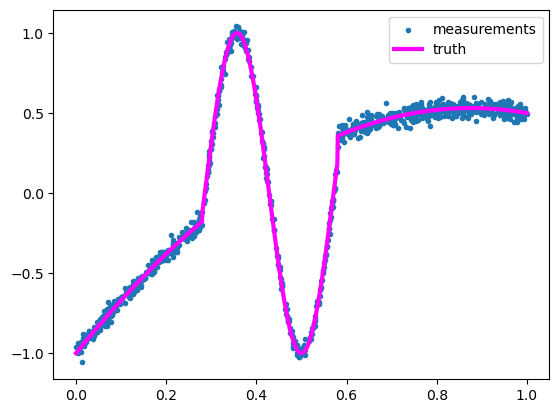

In [14]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)

ax.legend(["measurements", "truth"])

None

<br><br><br><br><br>

### Attempt 1: a linear fit

A linear fit is terrible because the curve isn't close to being linear.

In [15]:
# a linear fit can be computed analytically, which is nice
sum1 = len(x)
sumx = np.sum(x)
sumy = np.sum(y)
sumxx = np.sum(x**2)
sumxy = np.sum(x * y)
delta = (sum1 * sumxx) - (sumx * sumx)

slope = ((sum1 * sumxy) - (sumx * sumy)) / delta
intercept = ((sumxx * sumy) - (sumx * sumxy)) / delta

model_x = np.linspace(0, 1, 1000)
model_y = slope * model_x + intercept

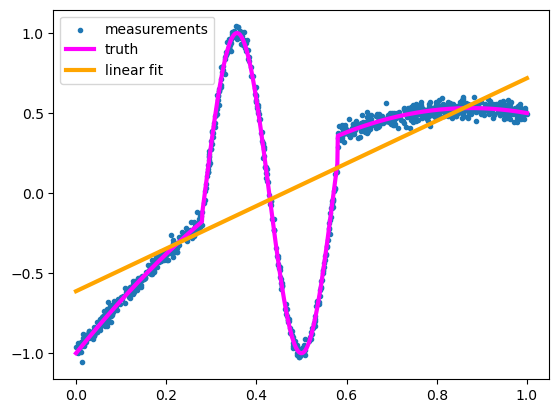

In [16]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", "linear fit"])

None

<br><br><br><br><br>

### Attempt 2: a theory-driven ansatz

A physicist's usual strategy is to find the underlying theory, even if some parameters are unknown (an "ansatz").

Suppose we _just know_ that the functional form is

$$ y = \left\{\begin{array}{l l}
\sin(C x) & \mbox{if } |x - A| < B \\
D + E x + F x^2 & \mbox{otherwise} \\
\end{array}\right. $$

for some $A$, $B$, $C$, $D$, $E$, $F$.

In [17]:
def ansatz(x, A, B, C, D, E, F):
    return np.where(abs(x - A) < B, np.sin(C*x), D + E*x + F*x**2)

In [18]:
from iminuit.cost import LeastSquares

In [19]:
# define a cost function that is minimized when the parameterized ansatz is equal to truth
least_squares = LeastSquares(x, y, 0.03, ansatz)

# set initial parameter values
minimizer = iminuit.Minuit(least_squares, A=0.43, B=0.15, C=22, D=-1, E=3.5, F=-2)
minimizer.migrad()

model_x = np.linspace(0, 1, 1000)
model_y = ansatz(model_x, **{p.name: p.value for p in minimizer.params})

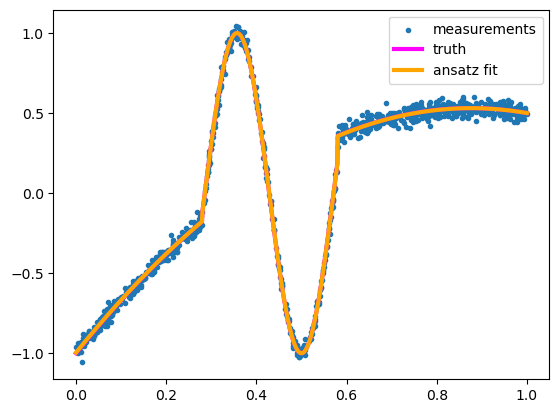

In [20]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", "ansatz fit"])

None

<br><br>

It's a great fit, but

* what if we don't know the functional form? or if it's super-complicated, like human behavior?
* the fit depends sensitively on the initial parameters and step size (try starting any of the parameters at the wrong value).

<br><br><br><br><br>

### Attempt 3: orthonormal basis functions

As physicists, we would approach a _generic_ unknown function with a [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), a [Fourier series](https://en.wikipedia.org/wiki/Fourier_series), or other sum of orthonormal basis functions ([Jacobi](https://en.wikipedia.org/wiki/Jacobi_polynomials), [Laguerre](https://en.wikipedia.org/wiki/Laguerre_polynomials), [Hermite](https://en.wikipedia.org/wiki/Hermite_polynomials), [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_polynomials), ...).

In [21]:
NUMBER_OF_POLYNOMIAL_TERMS = 15

# NumPy has a function for polynomial fits
# (which is analytic because it can be transformed into a linear fit)
coefficients = np.polyfit(x, y, NUMBER_OF_POLYNOMIAL_TERMS - 1)[::-1]

model_x = np.linspace(0, 1, 1000)
model_y = sum(c * model_x**i for i, c in enumerate(coefficients))

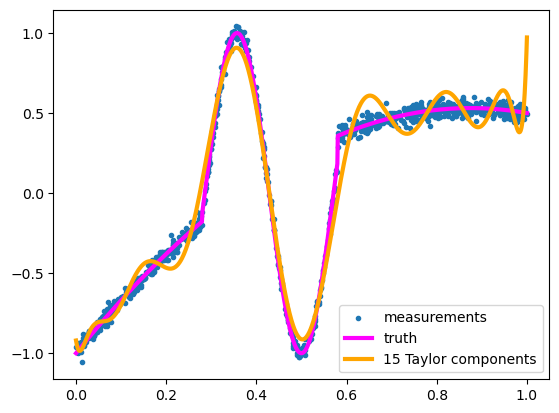

In [22]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{len(coefficients)} Taylor components"])

None

<br><br><br><br><br>

In [23]:
NUMBER_OF_COS_TERMS = 7
NUMBER_OF_SIN_TERMS = 7

# NumPy's FFT doesn't apply because the data aren't uniformly spaced, but we can compute a Fourier series with integrals
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y_sorted = y[sort_index]

constant_term = np.trapz(y_sorted, x_sorted)
cos_terms = [2*np.trapz(y_sorted * np.cos(2*np.pi * (i + 1) * x_sorted), x_sorted) for i in range(NUMBER_OF_COS_TERMS)]
sin_terms = [2*np.trapz(y_sorted * np.sin(2*np.pi * (i + 1) * x_sorted), x_sorted) for i in range(NUMBER_OF_SIN_TERMS)]

model_x = np.linspace(0, 1, 1000)
model_y = (
    constant_term +
    sum(coefficient * np.cos(2*np.pi * (i + 1) * model_x) for i, coefficient in enumerate(cos_terms)) +
    sum(coefficient * np.sin(2*np.pi * (i + 1) * model_x) for i, coefficient in enumerate(sin_terms))
)

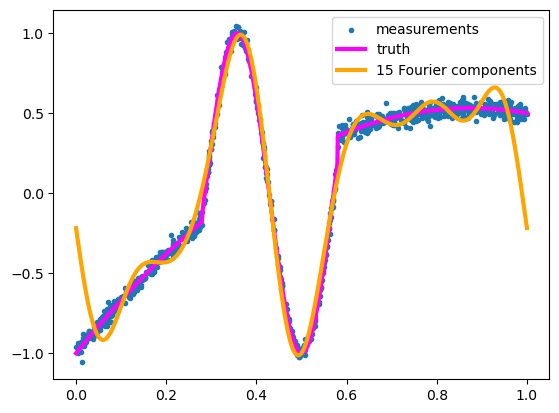

In [24]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{1 + len(cos_terms) + len(sin_terms)} Fourier components"])

None

<br><br>

The problem is that the true function is neither polynomial nor sinusoidal.

Convergence is slow and has artifacts.

<br><br><br><br><br>

### Attempt 4: adaptive basis functions

The classical methods (Taylor, Fourier, etc.) have one thing in common: they all use a fixed set of functions $\psi_i$ for discrete $i$:

$$ f(x) = \sum_i^N c_i \psi_i(x) $$

All that is allowed to vary in the fit are the coefficients $c_i$ in front of each function.

<br><br><br><br><br>

Suppose, instead, we had a set of functions that could also _change shape_:

$$ f(x) = \sum_i^N c_i \psi(x; \alpha_i, \beta_i) $$

For instance, the functions are sigmoids whose center $\alpha$ and width $\beta$ are adjustable:

$$ \psi(x; \alpha, \beta) = \frac{1}{1 + \exp\big((x - \alpha)/\beta\big)} $$

In [25]:
def sigmoid_component(x, center, width):
    # ignore NumPy errors when Minuit explores extreme values
    with np.errstate(over="ignore", divide="ignore"):
        return 1 / (1 + np.exp((x - center) / width))

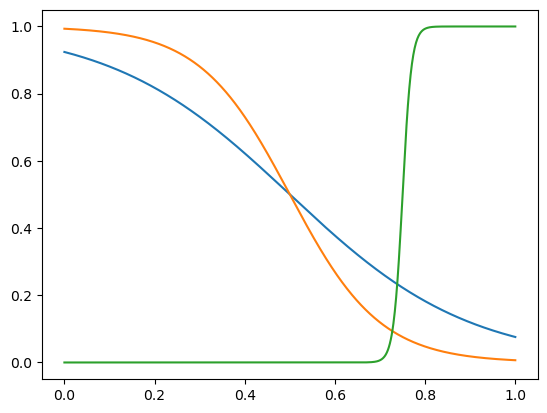

In [26]:
fig, ax = plt.subplots()

model_x = np.linspace(0, 1, 1000)

ax.plot(model_x, sigmoid_component(model_x, 0.5, 0.2))
ax.plot(model_x, sigmoid_component(model_x, 0.5, 0.1))
ax.plot(model_x, sigmoid_component(model_x, 0.75, -0.01))

None

<br><br><br><br><br>

In [27]:
NUMBER_OF_SIGMOIDS = 5

def sigmoid_sum(x, parameters):
    out = np.zeros_like(x)
    for coefficient, center, width in parameters.reshape(-1, 3):
        out += coefficient * sigmoid_component(x, center, width)
    return out

# using Minuit again
least_squares = LeastSquares(x, y, 0.03, sigmoid_sum)

# do best of 15 optimizations because this space has a lot more local minima
best_minimizer = None
for iteration in range(15):

    initial_parameters = np.zeros(5 * 3)
    initial_parameters[0::3] = np.random.normal(0, 1, NUMBER_OF_SIGMOIDS)    # coefficient terms
    initial_parameters[1::3] = np.random.uniform(0, 1, NUMBER_OF_SIGMOIDS)   # center parameters (alpha)
    initial_parameters[2::3] = np.random.normal(0, 0.1, NUMBER_OF_SIGMOIDS)  # width parameters (beta)

    minimizer = iminuit.Minuit(least_squares, initial_parameters)
    minimizer.migrad()

    if best_minimizer is None or minimizer.fval < best_minimizer.fval:
        best_minimizer = minimizer

model_x = np.linspace(0, 1, 1000)
model_y = sigmoid_sum(model_x, np.array(best_minimizer.values))

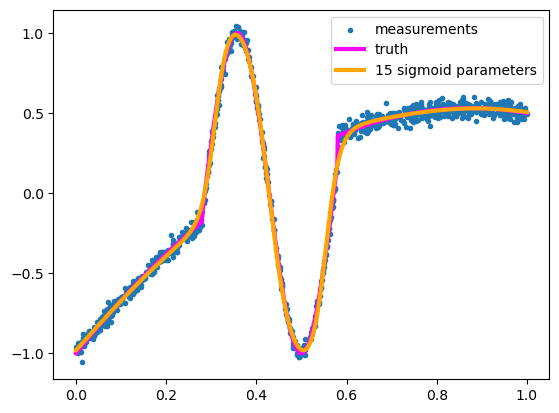

In [28]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.legend(["measurements", "truth", f"{len(minimizer.parameters)} sigmoid parameters"])

None

<br><br><br><br><br>

The fitter doesn't need very many sigmoids because it can position them and stretch them arbitrarily.

They can stack to build piecewise shapes.

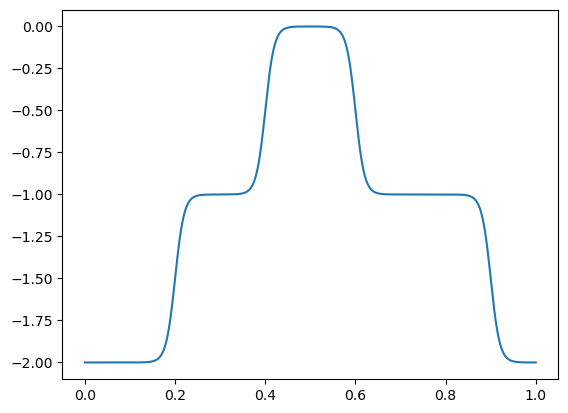

In [29]:
fig, ax = plt.subplots()

model_x = np.linspace(0, 1, 1000)

wide_plateau_left = sigmoid_component(model_x, 0.2, 0.01)
wide_plateau_right = sigmoid_component(model_x, 0.9, -0.01)

narrow_peak_left = sigmoid_component(model_x, 0.4, 0.01)
narrow_peak_right = sigmoid_component(model_x, 0.6, -0.01)

ax.plot(model_x, -wide_plateau_left - wide_plateau_right - narrow_peak_left - narrow_peak_right)

None

<br><br><br><br><br>

### Adaptive basis functions _are_ a neural network layer

Instead of a parameterized sigmoid,

$$ \psi(x; \alpha, \beta) = \frac{1}{1 + \exp\big((x - \alpha)/\beta\big)} $$

consider applying a linear transformation to the input of a sigmoid:

$$
x^{\mbox{\scriptsize layer 2}} = \frac{x^{\mbox{\scriptsize layer 1}} - \alpha}{\beta}
\mbox{\hspace{1 cm}and\hspace{1 cm}}
f(x^{\mbox{\scriptsize layer 2}}) = \frac{1}{1 + \exp\big( x^{\mbox{\scriptsize layer 2}} \big)}
$$

<br><br><br><br><br>

5 independently scaled sigmoids are a single hidden layer with 5 nodes:

$$
y =
c_i^{\mbox{\scriptsize L2--L3}} \cdot
f\left(\frac{x - \alpha_i^{\mbox{\scriptsize L1-L2}}}{\beta_i^{\mbox{\scriptsize L1-L2}}}\right)
$$

The 5 $\alpha$ and 5 $\beta$ parameters are the linear transformation from the input layer 1 to the hidden layer 2, the sigmoid $f$ is the activation function, and the coefficients in front of each sigmoid $c$ are the linear transformation from layer 2 to the output layer 3.

<img src="../img/artificial-neural-network-layers-3.svg" width="700">

<br><br><br><br><br>

To further demonstrate this, let's use a neural network implementation from Scikit-Learn to fit the same data.

In [30]:
import sklearn.neural_network

In [57]:
# do best of 15 optimizations because this space has a lot more local minima
best_neural_network = None
for iteration in range(15):

    # Scikit-Learn's MLPRegressor uses ordinary least squares as a loss function
    # the "logistic" activation function is our sigmoid
    neural_network = sklearn.neural_network.MLPRegressor(
        activation="logistic", hidden_layer_sizes=(5,),
        solver="lbfgs", max_iter=10000, alpha=0,
    )
    
    neural_network.fit(x[:, np.newaxis], y)

    if best_neural_network is None or neural_network.loss_ < best_neural_network.loss_:
        best_neural_network = neural_network

model_x = np.linspace(0, 1, 1000)
model_y = best_neural_network.predict(model_x[:, np.newaxis])

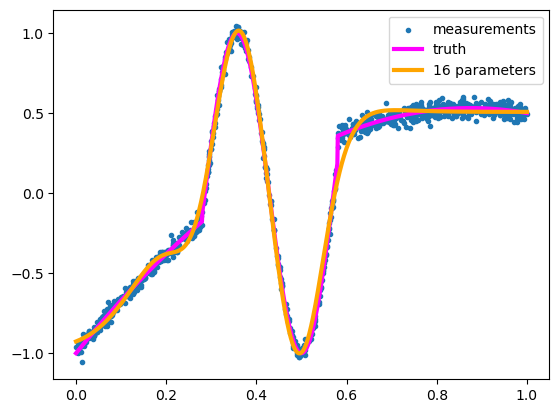

In [58]:
fig, ax = plt.subplots()

ax.scatter(x, y, marker=".")
ax.plot(np.linspace(0, 1, 1000), truth(np.linspace(0, 1, 1000)), color="magenta", linewidth=3)
ax.plot(model_x, model_y, color="orange", linewidth=3)

num_params = sum(x.size for x in neural_network.coefs_) + sum(x.size for x in neural_network.intercepts_)
ax.legend(["measurements", "truth", f"{num_params} parameters"])

None

(A real neural network has one more bias term per output variable than our analogy, so 16 parameters, not 15.)

<br><br><br><br><br>

Thus, a neural network with a hidden layer is a function approximator like Taylor and Fourier series, but with a special property: the basis functions are adaptive.

<br><br>

One consequence of this is that the basis functions are not orthogonal, like Taylor and Fourier series.

* Since Taylor and Fourier basis functions are orthogonal, they can be determined independently.
* Since a neural network's adaptive basis functions are not, they _must_ be determined by a combined fit.

<br><br>

In fact, parameters can be swapped: if $\{ \alpha_i \mbox{, } \beta_i \mbox{, } c_i \} \longleftrightarrow \{ \alpha_j \mbox{, } \beta_j \mbox{, } c_j \}$ for sigmoids $i$ and $j$, the function output is unchanged.

* Each minimum in the optimizer's objective function has $n!$ identical minima, for each hidden layer of size $n$.

<br><br>

It's a bumpy objective function!

<img src="../img/loss-visualization-noshort.png" width="600">

<br><br>

But that's usually okay because the space is high dimensional and therefore sparse ([this is a projection](https://www.cs.umd.edu/~tomg/projects/landscapes/)).

Also, there are better minimizers than Minuit.

<img src="../img/optimizers.gif">

<br><br>

If you want to learn a lot about optimizers, see [Why Momentum Really Works](https://distill.pub/2017/momentum/) for some great interactive demos, or [AdamW and Super-convergence is now the fastest way to train neural nets](https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html) for the bottom line: use AdamW and play with the "learning rate" parameter.